<a href="https://colab.research.google.com/github/Jionee/AI_colorization/blob/main/Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image Colorization

In [61]:
import os
import cv2
from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


Import Images

In [46]:
path = './drive/MyDrive/test'
#path = './Desktop/testData'
#print(os.listdir("./drive/MyDrive/testData"))

#Normalize images
train_datagen = ImageDataGenerator(rescale=1. / 255)
#Resize images, if needed
train = train_datagen.flow_from_directory(path,target_size=(256,256),batch_size=50,class_mode=None)
#print(train[0])
#step_per_epoch = 400 / 50 =8

#Convert from RGB to LAB
X = []
Y = []
for img in train[0]:
  try:
    lab = rgb2lab(img)
    X.append(lab[:,:,0])
    Y.append(lab[:,:,1:] / 128) #for normalize. Activation function is from -1 to 1
    
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #X and Y dimension should be same

print(X.shape)
print(Y.shape)



Found 5 images belonging to 2 classes.
(5, 256, 256, 1)
(5, 256, 256, 2)


Construct Model

In [47]:
model = Sequential()
#encoder
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

#decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 512)       1180160   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 512)       2

Training

In [50]:
model.fit(X,Y,validation_split=0.1, epochs=5, batch_size=8 )



Epoch 1/5
1/1 [==============================] - 0s 362ms/step - loss: 0.0229 - accuracy: 0.3654 - val_loss: 0.0229 - val_accuracy: 0.3639
Epoch 2/5
1/1 [==============================] - 0s 345ms/step - loss: 0.0247 - accuracy: 0.3656 - val_loss: 0.0068 - val_accuracy: 0.3535
Epoch 3/5
1/1 [==============================] - 0s 371ms/step - loss: 0.0232 - accuracy: 0.3577 - val_loss: 0.0097 - val_accuracy: 0.3524
Epoch 4/5
1/1 [==============================] - 0s 337ms/step - loss: 0.0222 - accuracy: 0.3608 - val_loss: 0.0289 - val_accuracy: 0.3683
Epoch 5/5
1/1 [==============================] - 0s 336ms/step - loss: 0.0268 - accuracy: 0.3663 - val_loss: 0.0101 - val_accuracy: 0.3775
INFO:tensorflow:Assets written to: ./sample_data/assets


In [55]:
model.save('./sample_data/variables/colorize_autoencoder.model')

INFO:tensorflow:Assets written to: ./sample_data/variables/colorize_autoencoder.model/assets


Test image

./drive/MyDrive/testData/Places365_val_00000023.jpg


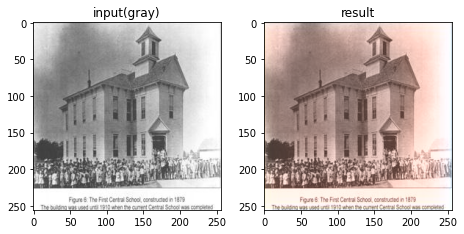

In [66]:
tf.keras.models.load_model(
    './sample_data/variables/colorize_autoencoder.model',
    custom_objects=None,
    compile=True
)

img1_color=[]
base = './drive/MyDrive/testData/Places365_val_'
img_num='00000023.jpg'
path = base + img_num
print(path)

img1=img_to_array(load_img(path))
img1=resize(img1,(256,256))
img1_color.append(img1)

img1_color = np.array(img1_color,dtype = float)
img1_color = rgb2lab(1.0/255 * img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))

output1 = model.predict(img1_color)
output1 = output1*128

result = np.zeros((256,256,3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]
imsave("result.png",lab2rgb(result))

#print
final = lab2rgb(result)
training = cv2.imread(path)

plt.figure(figsize=(20,20))
plt.subplot(5,5,1)
plt.title("input(gray)")
plt.imshow(training) 
plt.subplot(5,5,2)
plt.title("result")
plt.imshow(final)

